# Task 2: Create a Predictive Algorithm

In your second task, you were expected to create model that classifies your labels that done in the first task.
Create a model by using Python or R. You are free to choose your algorithm and libraries / packages to use.

Finally, tune your hyper-parameters of your model by randomized search, grid search or any other search method and explain your reasoning for this choice.

---

For this first test, we are going to use `xgboost` algorithm since it is really powerful in binary classification problems and has a really large list of advantages:

>__1. Regularization:__
>
>Standard GBM implementation has no regularization like XGBoost, therefore it also helps to reduce overfitting.
>In fact, XGBoost is also known as ‘regularized boosting‘ technique.
>
>__2. Parallel Processing:__
>
>XGBoost implements parallel processing and is blazingly faster as compared to GBM.
>But hang on, we know that boosting is sequential process so how can it be parallelized? We know that each tree can be built only after the previous one, so what stops us from making a tree using all cores? I hope you get where I’m coming from. Check this link out to explore further.
>XGBoost also supports implementation on Hadoop.
>
>__3. High Flexibility__
>
>XGBoost allow users to define custom optimization objectives and evaluation criteria.
>This adds a whole new dimension to the model and there is no limit to what we can do.
>
>__4. Handling Missing Values__
>
>XGBoost has an in-built routine to handle missing values.
>User is required to supply a different value than other observations and pass that as a parameter. XGBoost tries different things as it encounters a missing value on each node and learns which path to take for missing values in future.
>
>__5. Tree Pruning:__
>
>A GBM would stop splitting a node when it encounters a negative loss in the split. Thus it is more of a greedy algorithm.
>XGBoost on the other hand make splits upto the max_depth specified and then start pruning the tree backwards and remove splits beyond which there is no positive gain.
>Another advantage is that sometimes a split of negative loss say -2 may be followed by a split of positive loss +10. GBM would stop as it encounters -2. But XGBoost will go deeper and it will see a combined effect of +8 of the split and keep both.
>
>__6. Built-in Cross-Validation__
>
>XGBoost allows user to run a cross-validation at each iteration of the boosting process and thus it is easy to get the exact optimum number of boosting iterations in a single run.
>This is unlike GBM where we have to run a grid-search and only a limited values can be tested.
>
>__7. Continue on Existing Model__
>
>User can start training an XGBoost model from its last iteration of previous run. This can be of significant advantage in certain specific applications.
>GBM implementation of sklearn also has this feature so they are even on this point.

In [124]:
import numpy as np
import pandas as pd

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.model_selection import train_test_split

from matplotlib import pyplot
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

import warnings
warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)

In [125]:
df = pd.read_csv('./data/Courier_data.csv')

In [126]:
df.head()

,courier,week,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,lifetime_1,lifetime_2,flag
0,3767,2,6,34,38,0.0789,0.9211,140.4737,0.1316,2162.4737,...,8,20.208158,5.236316,0.8158,43.384804,1,19,2,33.0,1
1,3767,4,-1,42,37,0.0000,1.0000,135.5946,0.0811,2097.4054,...,19,18.855405,5.689459,0.8919,35.078042,3,11,2,33.0,1
2,3767,5,24,41,43,0.0233,0.9767,131.0930,0.0233,2043.8837,...,16,18.925116,5.138605,0.9302,31.455285,1,10,2,33.0,1
3,3767,6,-22,65,66,0.0606,0.9394,120.1515,0.0000,2124.2727,...,33,18.259697,4.704394,0.7879,34.252991,1,30,2,33.0,1
4,6282,2,9,33,27,0.0741,0.9259,100.0000,0.0370,4075.7407,...,5,26.863704,4.828519,0.8889,46.478114,1,4,1,35.0,0


---

## Preprocessing

In [127]:
df.describe()

,courier,week,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,lifetime_1,lifetime_2,flag
count,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,...,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000
mean,368198.358347,3.292231,-2.893223,43.383140,54.476033,0.076942,0.923059,104.688290,0.065939,4070.988724,...,20.252893,20.032864,5.293364,0.764485,70.344298,2.207273,13.469752,1.524298,30.229091,0.349091
std,127993.952842,2.252106,16.372872,23.770959,30.592909,0.072091,0.072091,8.809467,0.065232,1298.174332,...,12.224470,3.276434,0.981991,0.168306,18.660267,1.487941,12.423356,0.814969,12.170176,0.476762
min,3767.000000,0.000000,-138.000000,1.000000,1.000000,0.000000,0.000000,92.857100,0.000000,1445.666700,...,0.000000,7.140000,3.507143,0.000000,2.957809,1.000000,1.000000,1.000000,-61.000000,0.000000
25%,281494.000000,1.000000,-11.000000,26.000000,31.000000,0.026700,0.888900,100.000000,0.014700,2761.015900,...,11.000000,18.145942,4.607222,0.722200,59.786836,1.000000,5.000000,1.000000,24.000000,0.000000
50%,406948.000000,3.000000,-2.000000,40.000000,51.000000,0.062500,0.937500,100.750000,0.051700,4167.511100,...,19.000000,19.662683,5.169545,0.802000,73.398889,2.000000,11.000000,1.000000,30.000000,0.000000
75%,467864.000000,5.000000,6.000000,57.000000,74.000000,0.111100,0.973300,105.400000,0.098200,4941.105300,...,27.000000,21.400312,5.728191,0.867600,83.759259,3.000000,17.000000,2.000000,37.000000,1.000000
max,519341.000000,7.000000,77.000000,169.000000,184.000000,1.000000,1.000000,197.739100,0.666700,12593.900000,...,82.000000,66.400000,10.917143,1.000000,180.861111,13.000000,195.000000,4.000000,66.000000,1.000000


In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3025 entries, 0 to 3024
Data columns (total 22 columns):
courier       3025 non-null int64
week          3025 non-null int64
feature_1     3025 non-null int64
feature_2     3025 non-null int64
feature_3     3025 non-null int64
feature_4     3025 non-null float64
feature_5     3025 non-null float64
feature_6     3025 non-null float64
feature_7     3025 non-null float64
feature_8     3025 non-null float64
feature_9     3025 non-null float64
feature_10    3025 non-null float64
feature_11    3025 non-null int64
feature_12    3025 non-null float64
feature_13    3025 non-null float64
feature_14    3025 non-null float64
feature_15    3025 non-null float64
feature_16    3025 non-null int64
feature_17    3025 non-null int64
lifetime_1    3025 non-null int64
lifetime_2    3025 non-null float64
flag          3025 non-null int64
dtypes: float64(12), int64(10)
memory usage: 520.0 KB


No missings at this point.

<h6 class="text-muted">Standardization</h6>

Necessary since there are features with completely different scales.

In [129]:
from sklearn.preprocessing import StandardScaler

predictors = [x for x in df.columns if x not in ['flag', 'courier']]

scaler = StandardScaler()
df2 = pd.DataFrame(scaler.fit_transform(df[predictors]), columns=predictors)
df2['flag'] = df['flag']
df2['courier'] = df['courier']

<h6 class="text-muted">PCA to extract new features</h6>

Following the hint provided, new features (2) will be extracted from `feature_3` in combination with other ones. We will use PCA in an iterative way until we find the right combination of features such that the principal components have a large predictive power.

In [130]:
features = ['feature_3','lifetime_1','lifetime_2']

# Separating out the features
X = df2.loc[:, features].values

# Separating out the target
y = df2[['flag']]

In [131]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])

In [132]:
finalDf = pd.concat([principalDf, y], axis = 1)

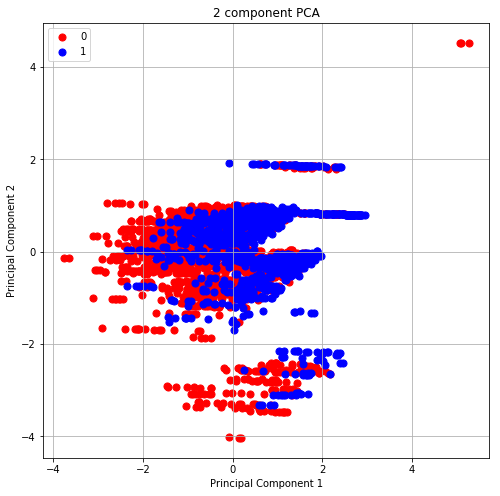

In [159]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('2 component PCA')
flags = [0,1]
colors = ['r','b']
for flag, color in zip(flags,colors):
    indicesToKeep = finalDf['flag'] == flag
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(flags)
ax.grid()

In [134]:
df3 = pd.concat([df2, finalDf[['PC1', 'PC2']]], axis=1)

In [135]:
predictors = [x for x in df3.columns if x not in ['flag', 'courier']]

In [136]:
# Choose all features except flag
features = [x for x in df3.columns if x not in ['flag']]
target = 'flag'

X = df3[features].values
y = df3[target].values

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [138]:
train = pd.DataFrame(X_train, columns=[features])
train[target] = list(y_train)

test = pd.DataFrame(X_test, columns=[features])
test[target] = y_test

Remove features not necessary for modelling:
* `feature_5`: we have seen that has complete negative correlation with `feature_4`.
* `lifetime_1`: already included in PCA features.

In [139]:
predictors.remove('feature_5')
predictors.remove('lifetime_1')

---
<h2>Model 1 <span class="text-muted">SVM</span></h2>

In [153]:
from sklearn.svm import LinearSVC

clf = LinearSVC(random_state=0)
clf.fit(train[predictors].values, train['flag'].values.flatten())

#print(clf.coef_)
#print(clf.intercept_)

print( "\nModel Report (Train)")
print( "AUC Score: %f" % roc_auc_score(train['flag'].values, clf.predict(train[predictors].values)))

print( "\nModel Report (Test)")
print( "AUC Score: %f" % roc_auc_score(test['flag'].values, clf.predict(test[predictors].values)))


Model Report (Train)
AUC Score: 0.691871

Model Report (Test)
AUC Score: 0.674636


---
<h2>Model 2 <span class="text-muted">Lasso</span></h2>

In [154]:
from sklearn.linear_model import Lasso

clf = Lasso(alpha=0.001, random_state=0)
clf.fit(train[predictors].values, train['flag'].values)

print( "\nModel Report (Train)")
print( "AUC Score: %f" % roc_auc_score(train['flag'].values, clf.predict(train[predictors].values)))

print( "\nModel Report (Test)")
print( "AUC Score: %f" % roc_auc_score(test['flag'].values, clf.predict(test[predictors].values)))


Model Report (Train)
AUC Score: 0.789857

Model Report (Test)
AUC Score: 0.792427


---
<h2>Model 3 <span class="text-muted">XGBoost</span></h2>

In [83]:
def modelfit(alg, dtrain, dtest, predictors, verbose=0, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values.flatten())
        cvresult = xgb.cv(
            xgb_param, 
            xgtrain, 
            num_boost_round=alg.get_params()['n_estimators'], 
            nfold=cv_folds,
            metrics='auc', 
            early_stopping_rounds=early_stopping_rounds, 
            verbose_eval=verbose)
        alg.set_params(n_estimators=cvresult.shape[0])
        print(alg.get_params())
    
    # Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target].values.flatten(),eval_metric='auc')
        
    # Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    # Print model report:
    print( "\nModel Report (Train)")
    print( "Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print( "AUC Score: %f" % metrics.roc_auc_score(dtrain[target].values, dtrain_predprob))
    
    # Predict validation set:
    dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]

    # Print model report:
    print( "\nModel Report (Test)")
    print( "AUC Score: %f" % metrics.roc_auc_score(dtest[target].values, dtest_predprob))
    
    features_df = pd.DataFrame({'feature': pd.Series(predictors), 'importance': alg.feature_importances_})
    features_df = features_df.sort_values('importance', ascending=False)
    ind = np.arange(len(features_df['feature'].values))    # the x locations for the groups
    
    pyplot.figure(num=None, figsize=[12,4])
    pyplot.bar(range(len(features_df)), features_df['importance'].values)
    pyplot.xticks(ind, features_df['feature'].values, rotation='vertical')
    pyplot.ylabel('Feature Importance Score')
    pyplot.show()

In order to decide on boosting parameters, we need to set some initial values of other parameters. Lets take the following values:

* __max_depth = 5:__ This should be between 3-10. I’ve started with 5 but you can choose a different number as well. 4-6 can be good starting points.
* __min_child_weight = 1:__ A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups.
* __gamma = 0:__ A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later.
* __subsample, colsample_bytree = 0.8:__ This is a commonly used used start value. Typical values range between 0.5-0.9.
* __scale_pos_weight = 1:__ Because of high class imbalance.

Please note that all the above are just initial estimates and will be tuned later. Lets take a low __learning rate of 0.1__ here and check the optimum number of trees using cv function of xgboost. The function defined above will do it for us.

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 133, 'n_jobs': 1, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 27, 'silent': True, 'subsample': 0.8}

Model Report (Train)
Accuracy : 0.9658
AUC Score: 0.994757

Model Report (Test)
AUC Score: 0.845097


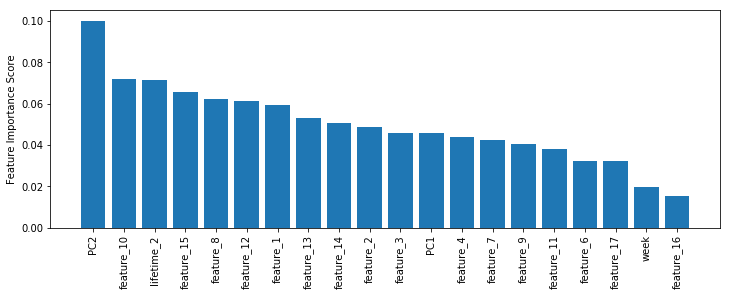

In [84]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb1, train, test, predictors)

## GridSearch

A search consists of:
* an estimator (regressor or classifier such as sklearn.svm.SVC());
* a parameter space;
* a method for searching or sampling candidates;
* a cross-validation scheme; and
* a score function.

<h6 class="text-muted">Step 1: Tune max_depth and min_child_weight</h6>

We tune these first as they will have the highest impact on model outcome. To start with, let’s set wider ranges and then we will perform another iteration for smaller ranges.

In [85]:
from sklearn.model_selection import GridSearchCV #Perforing grid search

param_test1 = {
 'max_depth':list(range(3,10,2)),
 'min_child_weight':list(range(1,6,2))
}

gsearch1 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate =0.1, 
        n_estimators=300, 
        max_depth=5,
        min_child_weight=1, 
        gamma=0, 
        subsample=0.8, 
        colsample_bytree=0.8,
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1, 
        seed=27,
        verbose_eval=1),
    param_grid = param_test1, scoring='roc_auc', n_jobs=4, iid=False, cv=5, return_train_score=False)

gsearch1.fit(train[predictors].values, train[target].values.flatten())

#gsearch1.cv_results_, 
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 9, 'min_child_weight': 1}, 0.8289158879664533)

There is high risk of overfitting for such large value for `max_depth`. Therefore, we are going to explore a narrower parameter space which should yield better results when generalising to test dataset.

In [86]:
param_test2 = {
 'max_depth':[3,4,5],
 'min_child_weight':[1,2,3]
}

gsearch2 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate=0.1,
        n_estimators=300,
        max_depth=5,
        min_child_weight=2,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27), 
    param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5, return_train_score=True)

gsearch2.fit(train[predictors].values,train[target].values.flatten())

#gsearch2.cv_results_, 
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 5, 'min_child_weight': 2}, 0.8293294510883747)

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 2, 'missing': None, 'n_estimators': 135, 'n_jobs': 1, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 27, 'silent': True, 'subsample': 0.8}

Model Report (Train)
Accuracy : 0.957
AUC Score: 0.992474

Model Report (Test)
AUC Score: 0.845291


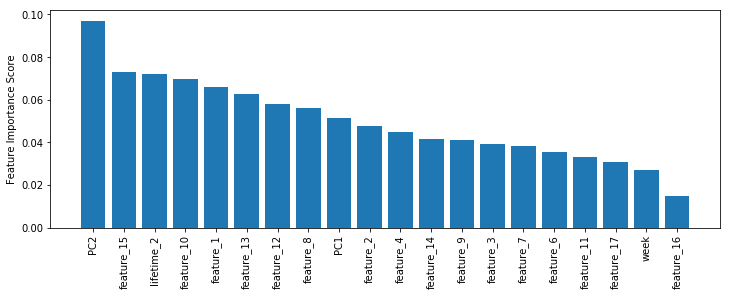

({'max_depth': 5, 'min_child_weight': 2}, 0.8293294510883747)

In [87]:
modelfit(gsearch2.best_estimator_, train, test, predictors)
gsearch2.best_params_, gsearch2.best_score_

The optimal values are `max_depth` = 5 and `min_child_weight` = 2, for now.

<h6 class="text-muted">Step 2: Tune gamma</h6>

Now let's tune gamma value using the parameters already tuned above. 

In [88]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

gsearch3 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate =0.1, 
        n_estimators=300, 
        max_depth=5,
        min_child_weight=2, 
        gamma=0, 
        subsample=0.8, 
        colsample_bytree=0.8,
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1, 
        seed=27,
        verbose_eval=1),
    param_grid = param_test3, scoring='roc_auc', n_jobs=4, iid=False, cv=5, return_train_score=True)

gsearch3.fit(train[predictors].values, train[target].values.flatten())

gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.0}, 0.8293294510883747)

This shows that our original value of `gamma` = 0 was optimal. Before proceeding, a good idea would be to re-calibrate the number of boosting rounds for the updated parameters.

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 2, 'missing': None, 'n_estimators': 135, 'n_jobs': 1, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 27, 'silent': True, 'subsample': 0.8}

Model Report (Train)
Accuracy : 0.957
AUC Score: 0.992474

Model Report (Test)
AUC Score: 0.845291


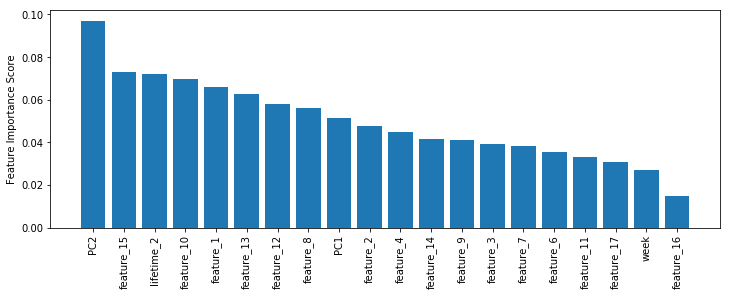

In [89]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=2,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb2, train, test, predictors)

Here, we can see the improvement in score. So the final parameters are:

* `max_depth`: 5
* `min_child_weight`: 2
* `gamma`: 0

Nonetheless, if we manually raise the value of `gamma` to 0.1 the results improve both in the train and test set.

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 2, 'missing': None, 'n_estimators': 155, 'n_jobs': 1, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 27, 'silent': True, 'subsample': 0.8}

Model Report (Train)
Accuracy : 0.9669
AUC Score: 0.995703

Model Report (Test)
AUC Score: 0.856262


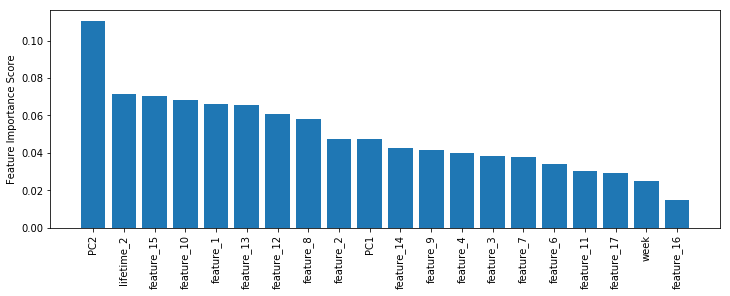

In [90]:
xgb2b = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=2,
 gamma=0.1,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb2b, train, test, predictors)

<h6 class="text-muted">Step 3: Tune subsample and colsample_bytree</h6>

The next step would be try different `subsample` and `colsample_bytree` values. Lets do this in 2 stages as well and take values 0.6,0.7,0.8,0.9 for both to start with. 

In [91]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch4 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate =0.1, 
        n_estimators=300, 
        max_depth=5,
        min_child_weight=2, 
        gamma=0.1, 
        subsample=0.8, 
        colsample_bytree=0.8,
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1, 
        seed=27,
        verbose_eval=1),
    param_grid = param_test4, scoring='roc_auc', n_jobs=4, iid=False, cv=5, return_train_score=True)

gsearch4.fit(train[predictors].values, train[target].values.flatten())

gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.8, 'subsample': 0.9}, 0.8339379955193346)

Here, we found 0.8 as the optimum value for `colsample_bytree` and 0.9 for `subsample`. Now we should try values in 0.05 interval around these.

In [92]:
param_test5 = {
 'subsample':[i/100.0 for i in range(80,95,5)],
 'colsample_bytree':[i/100.0 for i in range(80,95,5)]
}

gsearch5 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate =0.1, 
        n_estimators=300, 
        max_depth=5,
        min_child_weight=2, 
        gamma=0.1, 
        subsample=0.8, 
        colsample_bytree=0.8,
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1, 
        seed=27,
        verbose_eval=1),
    param_grid = param_test5, scoring='roc_auc', n_jobs=4, iid=False, cv=5, return_train_score=True)

gsearch5.fit(train[predictors].values, train[target].values.flatten())

gsearch5.best_params_, gsearch5.best_score_

({'colsample_bytree': 0.9, 'subsample': 0.85}, 0.8344829540442624)

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.85, 'gamma': 0.1, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 2, 'missing': None, 'n_estimators': 158, 'n_jobs': 1, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 27, 'silent': True, 'subsample': 0.9}

Model Report (Train)
Accuracy : 0.968
AUC Score: 0.995684

Model Report (Test)
AUC Score: 0.853641


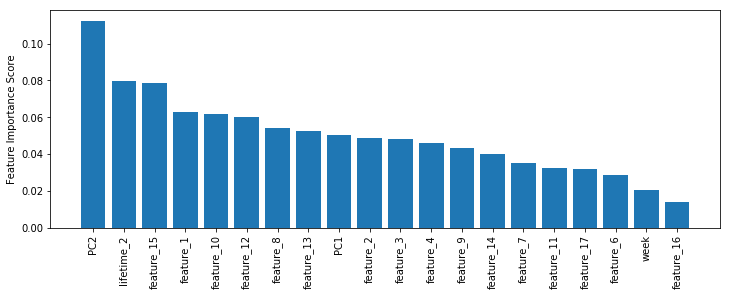

In [93]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=2,
 gamma=0.1,
 subsample=0.9,
 colsample_bytree=0.85,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb3, train, test, predictors)

The optimum values are:

* `subsample`: 0.90
* `colsample_bytree`: 0.85

However, 0.80 for both values works better.

<h6 class="text-muted">Step 4: Tuning Regularization Parameters</h6>

Next step is to apply regularization to reduce overfitting. Though many people don’t use this parameters much as `gamma` provides a substantial way of controlling complexity. But we should always try it. I’ll tune `reg_alpha` value here and leave it upto you to try different values of `reg_lambda`.

In [94]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch6 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate =0.1, 
        n_estimators=300, 
        max_depth=5,
        min_child_weight=2, 
        gamma=0.1, 
        subsample=0.8, 
        colsample_bytree=0.8,
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1, 
        seed=27,
        verbose_eval=1),
    param_grid = param_test6, scoring='roc_auc', n_jobs=4, iid=False, cv=5, return_train_score=True)

gsearch6.fit(train[predictors].values, train[target].values.flatten())

gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

({'mean_fit_time': array([0.99978771, 0.96529431, 0.96960297, 0.99821892, 0.27770276]),
  'std_fit_time': array([0.02461732, 0.00942681, 0.03872185, 0.01539565, 0.01183257]),
  'mean_score_time': array([0.01182709, 0.0111464 , 0.01071196, 0.0128479 , 0.00168729]),
  'std_score_time': array([1.25717368e-03, 2.29386404e-03, 9.26456122e-04, 3.81259202e-03,
         3.58548569e-05]),
  'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 1e-05},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.1},
   {'reg_alpha': 1},
   {'reg_alpha': 100}],
  'split0_test_score': array([0.80628272, 0.80879699, 0.8036945 , 0.8054397 , 0.7399651 ]),
  'split1_test_score': array([0.83565534, 0.83743012, 0.84886266, 0.83790339, 0.75944331]),
  'split2_test_score': array([0.8323572 , 0.82911823, 0.83040495, 0.8396338 , 0.75678114]),
  'split3_test_score': array([0.8413

You can see that we got a better CV. Now we can apply this regularization in the model and look at the impact:

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 2, 'missing': None, 'n_estimators': 236, 'n_jobs': 1, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 1, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 27, 'silent': True, 'subsample': 0.8}

Model Report (Train)
Accuracy : 0.9919
AUC Score: 0.999649

Model Report (Test)
AUC Score: 0.858544


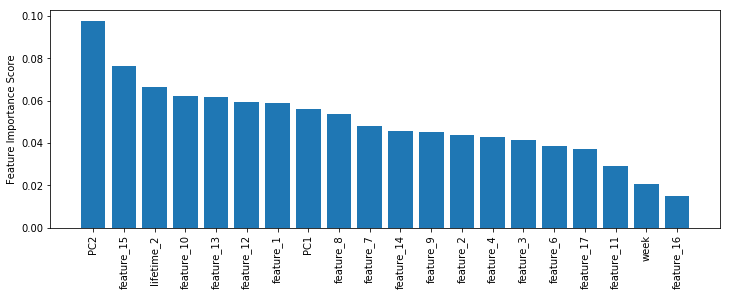

In [95]:
xgb4 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=2,
 gamma=0.1,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=1,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb4, train, test, predictors)

<h6 class="text-muted">Step 5: Reducing the Learning Rate</h6>

Lastly, we should lower the learning rate and add more trees. Lets use the cv function of XGBoost to do the job again.

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 2, 'missing': None, 'n_estimators': 1216, 'n_jobs': 1, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 2, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 27, 'silent': True, 'subsample': 0.8}

Model Report (Train)
Accuracy : 0.9401
AUC Score: 0.986031

Model Report (Test)
AUC Score: 0.842184


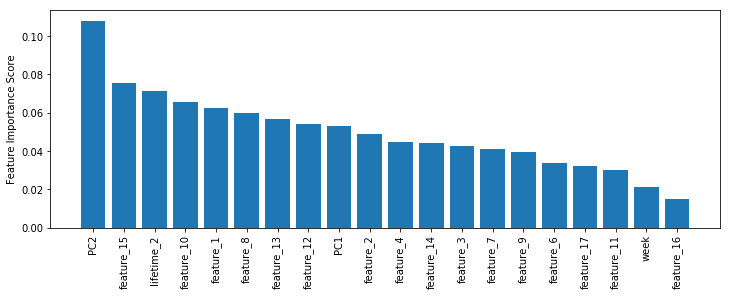

In [96]:
xgb5 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=5,
 min_child_weight=2,
 gamma=0.1,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=2,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb5, train, test, predictors)

Reducing the `learning_rate` did no work as expected and the score reduced slightly.